# Production Planning

In [78]:
from io import StringIO

import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt

# Data from Problem 12.3 from the book Model Building in Mathematical Programming (H. Paul Williams)
# Two entries in the top row changed

file = StringIO("""
10 6 8 4 11 9 3
0.5 0.7 – – 0.3 0.2 0.5
0.1 0.2 – 0.3 – 0.6 –
0.2 – 0.8 – – – 0.6
0.05 0.03 – 0.07 0.1 – 0.08
 – – 0.01 – 0.05 – 0.05
 """)

# Column names for the big Data Frame
columns = ["Profit", "Grinding", "V_drilling", "H_drilling", "Boring", "Planing"]

production = pd.read_csv(file, header=None, sep="\s+", na_values=["–"]).fillna(0).T
production.columns = columns
production.reindex(list(range(production.shape[0])))
production.index.name = "Product"

# keep profit coefficients in a separate series
profit = production["Profit"]
production.drop("Profit", axis=1, inplace=True)

# A little modification to the profit data to make the products more "competitive" against each other
profit[0] = 7
profit[4] = 8

# Numbers of machines of different types
nb_machines = pd.Series(
    [4, 2, 3, 1, 1], index=["Grinding", "V_drilling", "H_drilling", "Boring", "Planing"]
)
# total hours per month = 24 working days times 8 hours
hours = 24 * 8

display("production", production)
display("profit", profit)

'production'

,Grinding,V_drilling,H_drilling,Boring,Planing
Product,,,,,
0,0.5,0.1,0.2,0.05,0.00
1,0.7,0.2,0.0,0.03,0.00
2,0.0,0.0,0.8,0.00,0.01
3,0.0,0.3,0.0,0.07,0.00
4,0.3,0.0,0.0,0.10,0.05
5,0.2,0.6,0.0,0.00,0.00
6,0.5,0.0,0.6,0.08,0.05


'profit'

Product
0    7.0
1    6.0
2    8.0
3    4.0
4    8.0
5    9.0
6    3.0
Name: Profit, dtype: float64

## Nominal Model

The nominal model for this production planning problem can be represented as

$$
\begin{align*}
\min \; &\; \sum_{p\in P} c_p x_p \\
\text{s.t.} \; &\; \sum_{p\in P} a_{p, r} x_p \leq b_r & \forall r\in R \\
& \; x_p \geq 0 & \forall p\in P
\end{align*}
$$

where

* decision variables $x_p$ is the production of product $p\in P$, 
* $c_p$ is the profit contribution of each unit of $p\in P$ produced, 
* $a_{r,p}$ are the hours of resource machine $r\in R$ required for each unit of $p\in P$, and
* $b_r = n_r H$ is the total hours of resource $r\in R$ where $n_r$ is the number of available machines of type $r$, and $H$ is the planning horizon in hours.

The following cell presents a function to create and solve a Pyomo model for the generic linear program, then calls that function using the example problem data.

$$
\begin{align*}
\min \; & \; c^\top x \\
\text{s.t.} \; & \; A x \leq b \\
& \; x \geq 0
\end{align*}
$$

In [79]:
# creating and solving a nominal production model

def lp(a, b, c, title=None):
    """Returns a generic linear program where data is given in Pandas DataFrames.
    """
    
    m = pyo.ConcreteModel(title)

    m.P = pyo.Set(initialize=c.index)
    m.R = pyo.Set(initialize=b.index)

    # Variables = how much of each product we make
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeReals)
    
    @m.Objective(sense=pyo.maximize)
    def objective(m):
        return c @ m.x

    @m.Constraint(m.R)
    def resource(m, r):
        return a[r] @ m.x <= b[r]
    
    pyo.SolverFactory("cbc").solve(m)
    
    return m


m = lp(a = production, 
       b = nb_machines * hours, 
       c = profit, 
       title = "Nominal Production Planning")

m.display()

Model Nominal Production Planning

  Variables:
    x : Size=7, Index=P
        Key : Lower : Value     : Upper : Fixed : Stale : Domain
          0 :     0 :       0.0 :  None : False : False : NonNegativeReals
          1 :     0 : 117.79141 :  None : False : False : NonNegativeReals
          2 :     0 :     720.0 :  None : False : False : NonNegativeReals
          3 :     0 :       0.0 :  None : False : False : NonNegativeReals
          4 :     0 : 1884.6626 :  None : False : False : NonNegativeReals
          5 :     0 :  600.7362 :  None : False : False : NonNegativeReals
          6 :     0 :       0.0 :  None : False : False : NonNegativeReals

  Objectives:
    objective : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 26950.67506

  Constraints:
    resource : Size=5
        Key        : Lower : Body               : Upper
            Boring :  None : 192.00000230000003 : 192.0
          Grinding :  None :         768.000007 : 768.0
   

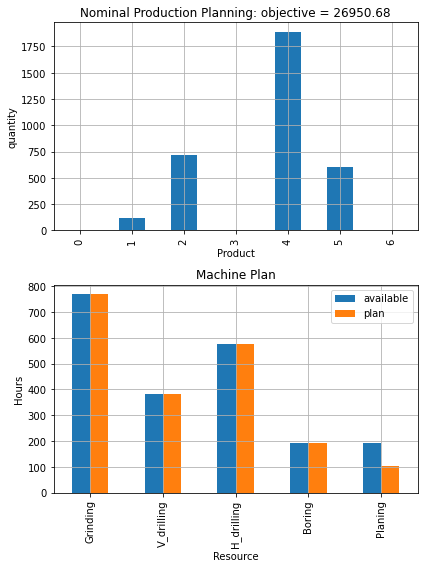

In [80]:
def display_plan(m, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(6, 8))

    x = pd.Series({p: m.x[p]() for p in m.P}, name=m.name)
    x.plot(ax=ax[0], kind="bar", xlabel="Product", ylabel="quantity",
           title=m.name  + f": objective = {m.objective():0.2f}", grid=True)

    resources = pd.concat([hours*nb_machines, production.T @ x], axis=1)
    resources.columns = ["available", "plan"]
    resources.plot(ax=ax[1], kind="bar", xlabel="Resource", ylabel="Hours", title="Machine Plan", grid=True)
    
    fig.tight_layout()
    
    return ax

display_plan(m);

## Is the Nominal Solution Robust to Uncertain Parameters?

Given a production plan, can the plan be executed with the available resources? 

If the linear program used to determine the plan accurately captures all of the resource constraints, then the answer should be yes. If the time required to perform each of the necessary operations are known with precision and accuracy, and if no other constraints are present, and if the computed solution satisfies all of the constraints in the problem, then it should be possible to execute the plan with the available resources.

But what if the parameters are not known with precision and accuracy?

Suppose, for example, that the time required to perform operation $r$ on product $p$, which has a nominal value $a_{r, p}$, could have any value between $a_{r, p} - a'_{r, p}$ and $a_{r, p} + a'_{r, p}$, where $a'_{r, p}$ is the maximum perturbation which defines an interval of possible parameters values. 



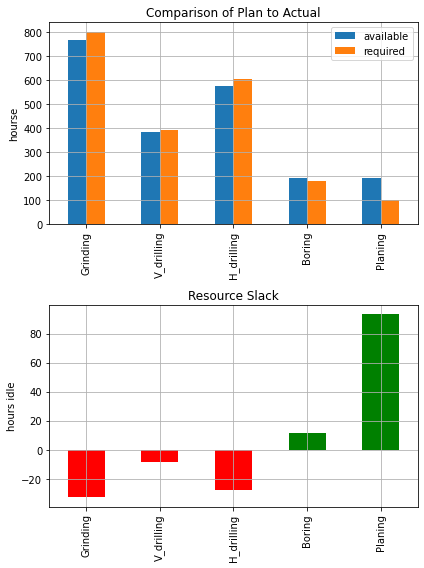

In [82]:
# define a nominal set of parameter values
dmax = 0.10
a_nominal = production
a_perturbation =  dmax * production

# solve for production plan using nominal parameter values
m_nominal = lp(a = a_nominal, 
               b = nb_machines * hours, 
               c = profit, 
               title = "Nominal Production Planning")

x_nominal = pd.Series({p: m_nominal.x[p]() for p in m.P})

# create a typical scenario
z = np.random.uniform(low=-1, high=1, size=a_perturbation.shape)
a = a_nominal + z * a_perturbation

# can the nominal plan be executed for a typical scenario?
b = pd.concat([nb_machines * hours, a.T @ x_nominal], axis=1)
b.columns = ["available", "required"]
b["slack"] = b["available"] - b["required"]

fig, ax = plt.subplots(2, 1, figsize=(6, 8))

b[["available", "required"]].plot(ax=ax[0], kind="bar", grid=True, 
                                  ylabel="hourse", title="Comparison of Plan to Actual")
b["slack"].plot(ax=ax[1], kind="bar", grid=True, legend=False, title="Resource Slack",
               color=(b["slack"] > 0).map({True: 'g', False: 'r'}), ylabel="hours idle")
fig.tight_layout()

For a more systematic assessment of the "here-and-now" decision to use the nominal production plan, the following cell simulates the resource requirements for $N$ scenarios that are possible for the given uncertainty set.

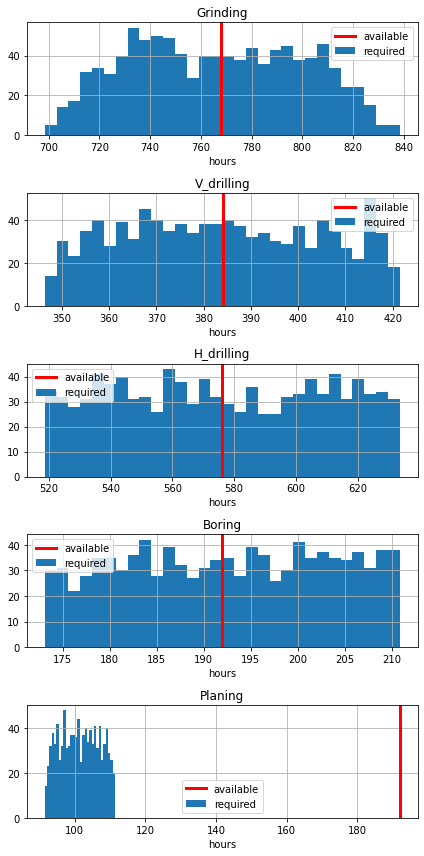

In [168]:
dmax = 0.10
a_nominal = production
a_perturbation =  dmax * production

# solve for production plan using nominal parameter values
m_nominal = lp(a = a_nominal, 
               b = nb_machines * hours, 
               c = profit, 
               title = "Nominal Production Planning")

x_nominal = pd.Series({p: m_nominal.x[p]() for p in m.P})

s = []

N = 1000
for n in range(N):
    z = np.random.uniform(low=-1, high=1, size=a_perturbation.shape)
    a = a_nominal + z * a_perturbation
    s.append((a.T @ x_nominal).to_numpy())

s = pd.DataFrame(s, columns=a.columns)

fig, ax = plt.subplots(len(nb_machines), 1, figsize=(6, 12))
for k, r in enumerate(nb_machines.index):
    s[r].hist(ax=ax[k], bins=30)
    ax[k].set_title(r)
    ax[k].set_xlabel("hours")
    ax[k].axvline(nb_machines[r] * hours, lw=3, color="r")
    ax[k].legend(["available", "required"])

fig.tight_layout()

In [186]:
print(f"{N - (s <= nb_machines * hours).T.all().sum()} out of {N} simiulations violate at least one constraint.")

933 out of 1000 simiulations violate at least one constraint.


## "Wait-and-See" and the Case of Perfect Information

In [190]:
# simulate N "wait-and-see" production planning scenarios
X = []
s = []
N = 1000

for k in range(N):
    if 0 == k % 10:
        print(".", end="")
    z = np.random.uniform(low=-1, high=1, size=a_perturbation.shape)
    m = lp(a = a_nominal + z * a_perturbation,
            b = nb_machines * hours, 
            c = profit, 
            title = "Nominal Production Planning")
    s.append(m.objective())
    X.append([m.x[p]() for p in m.P])
    
X = pd.DataFrame(X, columns=profit.index)

....................................................................................................

24853.631419999998

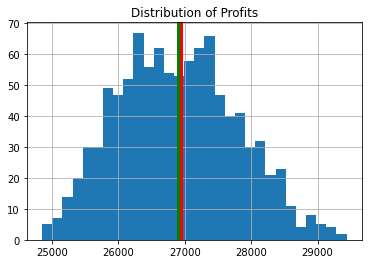

In [194]:
s = pd.Series(s)
ax = s.hist(bins=30)
ax.set_title("Distribution of Profits")
ax.axvline(m_nominal.objective(), color='r', lw=3)
ax.axvline(s.mean(), color='g', lw=3)
s.min()

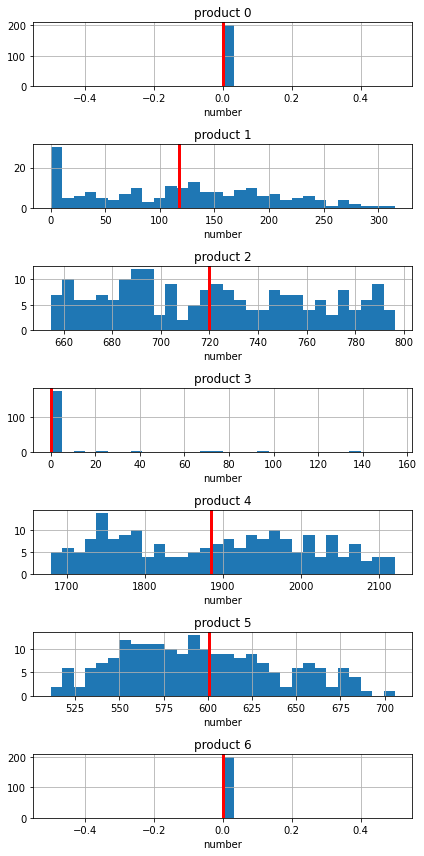

In [165]:
fig, ax = plt.subplots(len(profit), 1, figsize=(6, 12))
for k, p in enumerate(profit.index):
    X[p].hist(ax=ax[k], bins=30)
    ax[k].set_title(f"product {p}")
    ax[k].set_xlabel("number")
    ax[k].axvline(x_nominal[p], color='r', lw=3)

fig.tight_layout()

## Robust Optimization to the "Here-and-Now" Decision

The robust optimization problem is given by

$$
\begin{align*}
\min \; &\; \sum_{p\in P} c_p x_p \\
\text{s.t.} \; &\; \sum_{p\in P} \tilde{a}_{p, r} x_p \leq b_r & \forall r\in R \\
& \; x_p \geq 0 & \forall p\in P
\end{align*}
$$

where $\tilde{a}_{p, r}$ denotes an uncertain coefficient. The uncertainty is modeled as 

$$\tilde{a}_{p, r} = a_{p, r} + z_{p, r} a'_{p, r}$$

where $a'_{p, r}$ is the maximum perturbation in coefficient $a_{p, r}$, and 

$$
\begin{align*}
| z_{p, r} | & \leq 1 & \forall p\in P, r \in R\\
\sum_{p\in P} |z_{p, r}| & \leq d & \forall r\in R
\end{align*}
$$

where $d$ is the 'uncertainty budget'. Together, these constraints form the uncertainty set $\cal{Z}$. The first constraint is a 'box' (or 'unit box', or 'interval') constraint that limits the range of each $\tilde{a}_{r, p} \in [a_{r,p} - a'_{r,p}, a_{r,p} + a'_{r,p}]$. For each $r\in R$, the floor (or integer part) of $d$ determines the number of elements of $\tilde{a}_{r, p}$ for $\p in P$ that can simultaneously reach the limits of the interval.

In [189]:
def rc(a, a_perturbation, b, c, d=1, title=None):
    """Returns robust counterpart."""
    
    unc_budget = d
    
    m = pyo.ConcreteModel(title)

    m.P = pyo.Set(initialize=c.index)
    m.R = pyo.Set(initialize=b.index)

    # Variables = how much of each product we make
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeReals)
    
    # sensitivity
    m.lam = pyo.Var(m.R, domain=pyo.NonNegativeReals)
    m.s = pyo.Var(m.R, m.P, domain=pyo.NonNegativeReals)
    
    @m.Objective(sense=pyo.maximize)
    def objective(m):
        return c @ m.x
    
    @m.Expression(m.R)
    def robustness_margin(m, r):
        return pyo.quicksum(m.s[r, :]) + unc_budget * m.lam[r]
    
    @m.Constraint(m.R)
    def resource(m, r):
        return a[r] @ m.x + m.robustness_margin[r] <= b[r]
    
    @m.Constraint(m.R, m.P)
    def sensitivity(m, r, p):
        return m.s[r, p] >= a_perturbation.loc[p, r] * m.x[p] - m.lam[r]
    
    pyo.SolverFactory("cbc").solve(m)
    
    return m


m = rc(a = production, 
       a_perturbation = 0.10*production,
       b = nb_machines*hours,
       c = profit, 
       d = 1,
       title = "Robust Production Planning")

m.robustness_margin.display()
m.display()

robustness_margin : Size=5
    Key        : Value
        Boring :   17.0790751
      Grinding :    51.237226
    H_drilling :    52.363636
       Planing : 100.05916845
    V_drilling :   32.4059573
Model Robust Production Planning

  Variables:
    x : Size=7, Index=P
        Key : Lower : Value     : Upper : Fixed : Stale : Domain
          0 :     0 :       0.0 :  None : False : False : NonNegativeReals
          1 :     0 : 137.67237 :  None : False : False : NonNegativeReals
          2 :     0 : 654.54545 :  None : False : False : NonNegativeReals
          3 :     0 :       0.0 :  None : False : False : NonNegativeReals
          4 :     0 : 1707.9075 :  None : False : False : NonNegativeReals
          5 :     0 : 540.09928 :  None : False : False : NonNegativeReals
          6 :     0 :       0.0 :  None : False : False : NonNegativeReals
    lam : Size=5, Index=R
        Key        : Lower : Value     : Upper : Fixed : Stale : Domain
            Boring :     0 : 0.4130171 : 

In [167]:
production_plans.plot(kind="bar", xlabel="product", ylabel="quantity", title="Production Plans", grid=True)

NameError: name 'production_plans' is not defined

In [188]:
# compute profits for each plan by taking dot product
display(production_plans.T @ profit)

NameError: name 'production_plans' is not defined